# From Video to Behavior Labels

How do we know when the animal is being social? This notebook shows the pipeline:

**Video** → **SLEAP pose tracking** → **Distance between animals** → **Threshold** → **Social label**

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sleap_io as sio
import h5py

from src.constants import BEHAVIOR_FPS
from src.data import download_data, load_behavior, load_entrances, BEHAVIOR_KEYS

sns.set_theme(style='whitegrid', context='notebook', font_scale=1.1)
plt.rcParams['figure.dpi'] = 100

DATA_DIR = download_data()
print('Data ready.')

  [skip] calcium.00.h5 (238.6 MB)
  [skip] social_bouts.00.h5 (0.5 MB)
  [skip] SI3_2022_Entrance_Frames.xlsx (0.0 MB)
  [skip] spatial_footprints.00.h5 (33.8 MB)
  [skip] behavior_video.mp4 (37.6 MB)
  [skip] behavior_tracking.slp (10.1 MB)
Data ready.


---
## 1. The Behavioral Video

A top-down camera records a **resident mouse** in an arena at 25 fps. Halfway through (~300s), a **juvenile intruder** is introduced. The video captures their interactions.

In [2]:
# Load the SLEAP predictions (contains tracked poses)
preds = sio.load_file(str(DATA_DIR / 'behavior_tracking.slp'))

# Point to our local copy of the video
preds.video.replace_filename(str(DATA_DIR / 'behavior_video.mp4'))

print(f'Video: {preds.video.shape[0]} frames, {preds.video.shape[1]}x{preds.video.shape[2]} pixels')
print(f'Tracks: {[t.name for t in preds.tracks]}')
print(f'Body parts: {preds.skeleton.node_names}')

Video: 15020 frames, 300x504 pixels
Tracks: ['resident', 'intruder']
Body parts: ['nose', 'head', 'ear_left', 'ear_right', 'trunk', 'tti', 'tail_tip', 't0', 't1', 't2', 'neck', 'hindpaw_left', 'hindpaw_right', 'forepaw_left', 'forepaw_right']


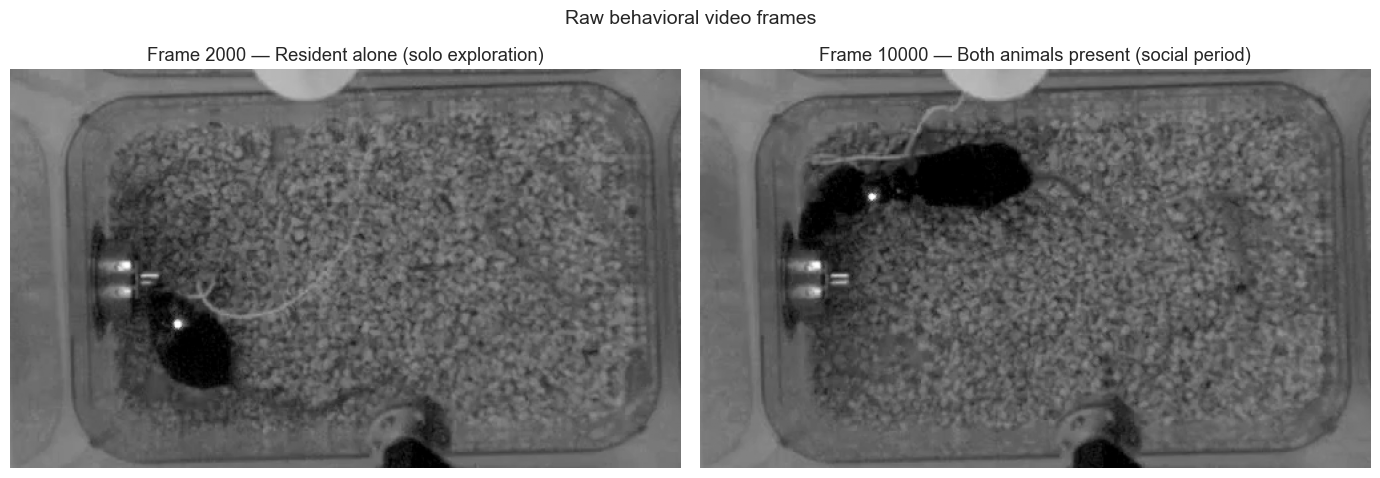

In [3]:
# Show a frame BEFORE the intruder enters — just the resident alone
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Solo frame (early in recording)
solo_frame = 2000
img_solo = preds.video[solo_frame]
axes[0].imshow(img_solo, cmap='gray')
axes[0].set_title(f'Frame {solo_frame} — Resident alone (solo exploration)')
axes[0].axis('off')

# Social frame (after intruder entry)
social_frame = 10000
img_social = preds.video[social_frame]
axes[1].imshow(img_social, cmap='gray')
axes[1].set_title(f'Frame {social_frame} — Both animals present (social period)')
axes[1].axis('off')

plt.suptitle('Raw behavioral video frames', fontsize=14)
plt.tight_layout()
plt.show()

---
## 2. SLEAP Pose Tracking

[SLEAP](https://sleap.ai/) tracks **15 body-part keypoints** on each animal (nose, head, ears, trunk, paws, tail, etc.). This gives us the precise location of every body part in every frame.

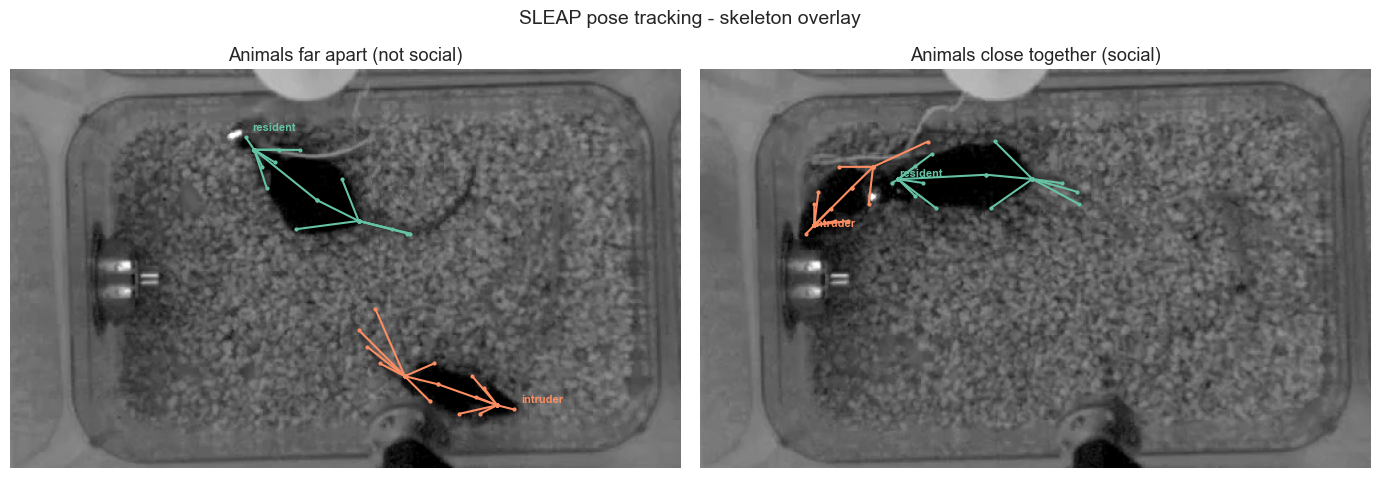

In [4]:
# Build lookup from frame_idx to labeled frame (for skeleton overlay)
frame_to_lf = {lf.frame_idx: lf for lf in preds}

# Show frames with SLEAP skeleton overlay
colors = sns.color_palette('Set2', n_colors=2)

def plot_skeleton(ax, frame_idx):
    """Plot video frame with SLEAP skeleton overlay."""
    img = preds.video[frame_idx]
    ax.imshow(img, cmap='gray')
    lf = frame_to_lf.get(frame_idx)
    if lf is None:
        return
    for inst in lf:
        pts = inst.numpy()
        track_idx = preds.tracks.index(inst.track)
        c = colors[track_idx]
        for src, dst in inst.skeleton.edge_inds:
            if not (np.isnan(pts[src]).any() or np.isnan(pts[dst]).any()):
                ax.plot(pts[[src, dst], 0], pts[[src, dst], 1], '.-',
                        color=c, lw=1.5, markersize=4)
        nose_idx = preds.skeleton.index('nose')
        if not np.isnan(pts[nose_idx]).any():
            ax.annotate(inst.track.name, pts[nose_idx],
                       fontsize=8, color=c, fontweight='bold',
                       textcoords='offset points', xytext=(5, 5))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_skeleton(axes[0], 9000)
axes[0].set_title('Animals far apart (not social)')
axes[0].axis('off')

plot_skeleton(axes[1], 10000)
axes[1].set_title('Animals close together (social)')
axes[1].axis('off')

plt.suptitle('SLEAP pose tracking - skeleton overlay', fontsize=14)
plt.tight_layout()
plt.show()

---
## 3. Nose-to-Body Distance → Social Labels

The rule is simple: if the **nose** of one animal is within **10 pixels** of any body part on the other animal, that frame is labeled as **social**. This captures sniffing, touching, and close investigation.

In [5]:
# Extract full tracking array: (n_frames, 2 tracks, 15 nodes, 2 xy)
n_frames_vid = preds.video.shape[0]
n_tracks = len(preds.tracks)
n_nodes = len(preds.skeleton)
nose_idx = preds.skeleton.index('nose')

trx = np.full((n_frames_vid, n_tracks, n_nodes, 2), np.nan)
for lf in preds:
    for inst in lf:
        track_idx = preds.tracks.index(inst.track)
        trx[lf.frame_idx, track_idx] = inst.numpy()

print(f'Tracking array: {trx.shape}')
print(f'  (frames, tracks, body_parts, xy)')

# Compute nose-to-all-body-parts distance for resident→intruder
resident_nose = trx[:, 0, nose_idx, :]   # (n_frames, 2)
intruder_body = trx[:, 1, :, :]           # (n_frames, 15, 2)

# Distance from resident nose to each intruder body part
diff = intruder_body - resident_nose[:, np.newaxis, :]  # (n_frames, 15, 2)
dists = np.sqrt((diff ** 2).sum(axis=-1))               # (n_frames, 15)
min_dist = np.nanmin(dists, axis=1)                     # (n_frames,)

print(f'\nResident nose → nearest intruder body part:')
print(f'  Min distance: {np.nanmin(min_dist):.1f} px')
print(f'  Median distance: {np.nanmedian(min_dist):.1f} px')

Tracking array: (15020, 2, 15, 2)
  (frames, tracks, body_parts, xy)

Resident nose → nearest intruder body part:
  Min distance: 0.0 px
  Median distance: 20.2 px


/var/folders/yt/5gdjwln55x9_stgx851x0yb80000gn/T/ipykernel_39248/2015915843.py:23: RuntimeWarning: All-NaN slice encountered
  min_dist = np.nanmin(dists, axis=1)                     # (n_frames,)


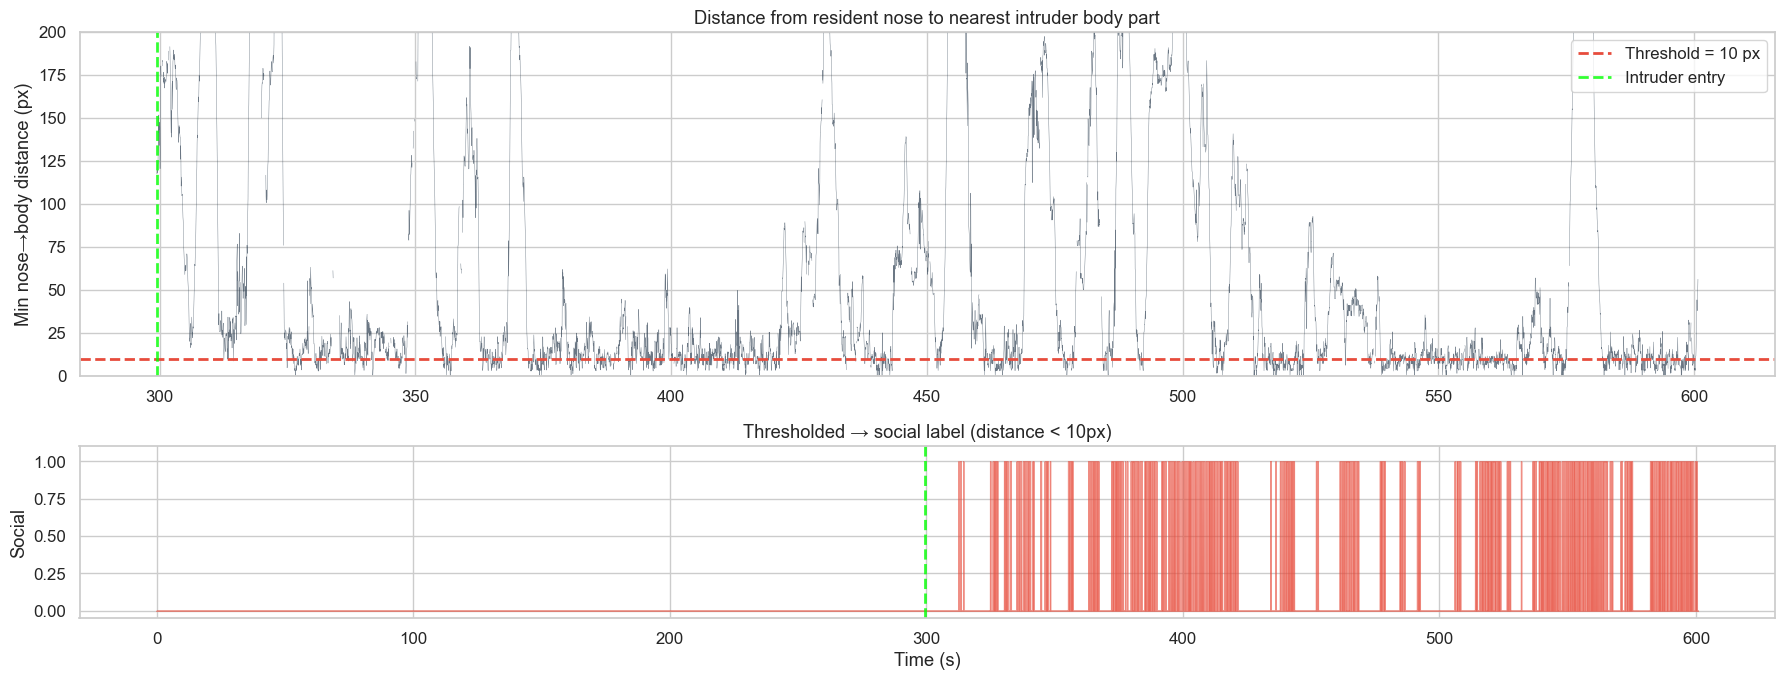

Frames below threshold: 1833 / 15020 (12.2%)


In [6]:
# Show the distance threshold in action
THRESH = 10  # pixels
t = np.arange(n_frames_vid) / BEHAVIOR_FPS
entry_approx = 7485  # Session 5 (this video)

fig, axes = plt.subplots(2, 1, figsize=(18, 7), gridspec_kw={'height_ratios': [2, 1]})

# Top: Distance timeseries
axes[0].plot(t, min_dist, color='#2c3e50', lw=0.3, alpha=0.7)
axes[0].axhline(THRESH, color='#e74c3c', lw=2, ls='--', label=f'Threshold = {THRESH} px')
axes[0].axvline(entry_approx / BEHAVIOR_FPS, color='lime', lw=2, ls='--',
                label='Intruder entry', alpha=0.8)
axes[0].set_ylabel('Min nose→body distance (px)')
axes[0].set_title('Distance from resident nose to nearest intruder body part')
axes[0].set_ylim(0, 200)
axes[0].legend(loc='upper right')

# Bottom: Thresholded → social label
is_close = min_dist < THRESH
axes[1].fill_between(t, 0, is_close.astype(float), color='#e74c3c', alpha=0.6)
axes[1].axvline(entry_approx / BEHAVIOR_FPS, color='lime', lw=2, ls='--', alpha=0.8)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Social')
axes[1].set_title('Thresholded → social label (distance < 10px)')
axes[1].set_ylim(-0.05, 1.1)

plt.tight_layout()
plt.show()

print(f'Frames below threshold: {is_close.sum()} / {n_frames_vid} ({is_close.mean():.1%})')

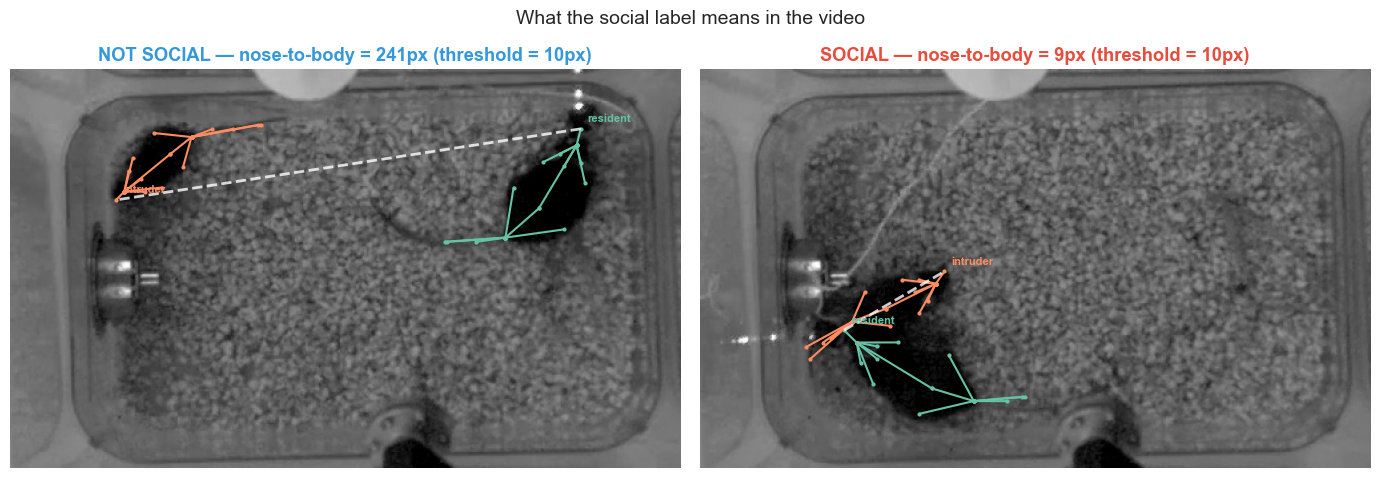

In [7]:
# Show what "social" vs "not social" looks like in the actual video
# Find frames where distance is small (social) vs large (solo)
post_entry_mask = np.arange(n_frames_vid) > entry_approx
valid = ~np.isnan(min_dist) & post_entry_mask

social_frames = np.where(valid & (min_dist < THRESH))[0]
solo_frames = np.where(valid & (min_dist > 80))[0]

ex_social = social_frames[len(social_frames) // 3]
ex_solo = solo_frames[len(solo_frames) // 3]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, fidx, label, dist_val in [
    (axes[0], ex_solo, 'NOT SOCIAL', min_dist[ex_solo]),
    (axes[1], ex_social, 'SOCIAL', min_dist[ex_social]),
]:
    plot_skeleton(ax, fidx)

    # Draw distance line between resident nose and nearest intruder point
    res_nose = trx[fidx, 0, nose_idx]
    int_nose = trx[fidx, 1, nose_idx]
    if not (np.isnan(res_nose).any() or np.isnan(int_nose).any()):
        ax.plot([res_nose[0], int_nose[0]], [res_nose[1], int_nose[1]],
                'w--', lw=2, alpha=0.8)

    border_color = '#e74c3c' if label == 'SOCIAL' else '#3498db'
    for spine in ax.spines.values():
        spine.set_edgecolor(border_color)
        spine.set_linewidth(4)
    ax.set_title(f'{label} — nose-to-body = {dist_val:.0f}px (threshold = {THRESH}px)',
                 color=border_color, fontweight='bold')
    ax.axis('off')

plt.suptitle('What the social label means in the video', fontsize=14)
plt.tight_layout()
plt.show()

---
## 4. The Full Ethogram

The EDGE pipeline computes more specific labels beyond just "social" — it distinguishes *who* is investigating *whom* and *which body region* is being sniffed. These are all derived from the same distance thresholding with different body-part pairings.

The composite `is_social` label we use for classification is the OR of all sub-types:

```
is_social = is_social_sender | is_social_receiver
          = (is_touching | is_ag_sniffing | is_of_sniffing)
          | (is_touched  | is_ag_sniffed  | is_of_sniffed)
```

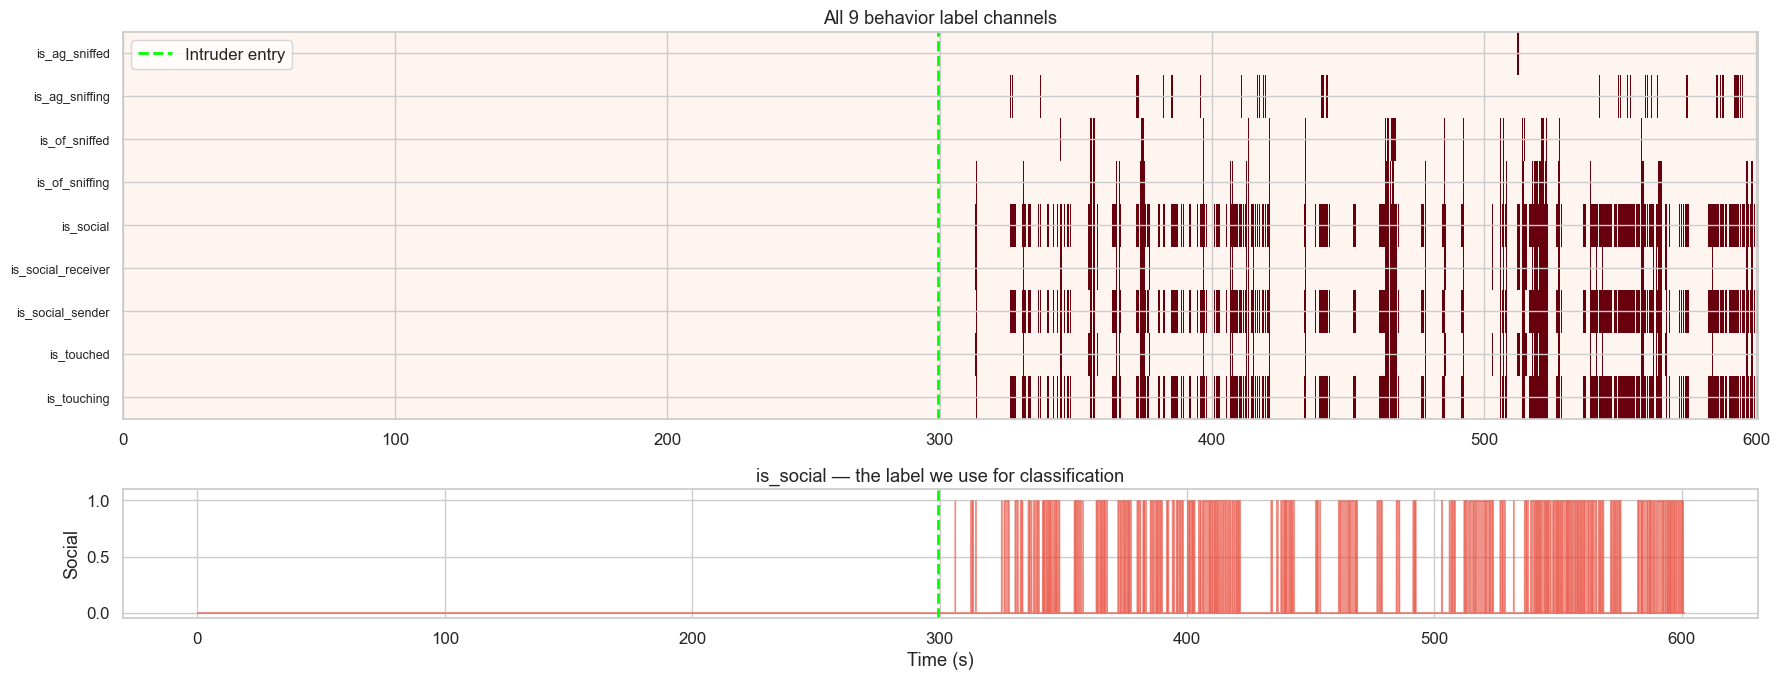

In [8]:
# Load the pre-computed behavior labels
entrances = load_entrances(DATA_DIR)
behavior = load_behavior(len(entrances), DATA_DIR)

# Session 5 corresponds to this video (animal 5-2)
sess_idx = 5
beh = behavior[sess_idx]
entry_frame = int(entrances.iloc[sess_idx]['Int_Entry'])

ethogram = np.stack([beh[k] for k in BEHAVIOR_KEYS], axis=0).astype(float)
t_beh = np.arange(ethogram.shape[1]) / BEHAVIOR_FPS

fig, axes = plt.subplots(2, 1, figsize=(18, 7), gridspec_kw={'height_ratios': [3, 1]})

axes[0].imshow(ethogram, aspect='auto', interpolation='nearest', cmap='Reds',
               extent=[t_beh[0], t_beh[-1], len(BEHAVIOR_KEYS), 0])
axes[0].set_yticks(np.arange(len(BEHAVIOR_KEYS)) + 0.5)
axes[0].set_yticklabels(BEHAVIOR_KEYS, fontsize=9)
axes[0].axvline(entry_frame / BEHAVIOR_FPS, color='lime', lw=2, ls='--',
                label=f'Intruder entry')
axes[0].set_title('All 9 behavior label channels')
axes[0].legend(loc='upper left')

axes[1].fill_between(t_beh, 0, beh['is_social'].astype(float),
                     color='#e74c3c', alpha=0.6)
axes[1].axvline(entry_frame / BEHAVIOR_FPS, color='lime', lw=2, ls='--')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Social')
axes[1].set_title('is_social — the label we use for classification')
axes[1].set_ylim(-0.05, 1.1)

plt.tight_layout()
plt.show()

---
## Summary

The social behavior labels come from a straightforward pipeline:

1. A **top-down video** records two mice in an arena at 25 fps
2. **SLEAP** tracks 15 body-part keypoints on each animal
3. If one animal's **nose** is within **10 pixels** of the other's body → that frame is labeled **social**
4. These labels are **resampled from 25 fps → 30 fps** and **aligned** to the calcium imaging timestamps for our analysis

No neural data is used in the labeling — the labels are purely from the behavioral video. This is what makes the classification question meaningful: can we predict these behaviorally-derived labels from the calcium signal alone?